# Hidden on Variation


## Define Envs

In [7]:
from pathlib import Path

env_name = "CARLAnt"

database = {
    "CARLDmcWalkerEnv": {  # STATUS: Done
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-12-14/10-47-33_benchmark_train",
        "folders_eval": [
            # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-08/10-48-37",  # old magnitudes
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-14/14-09-02",  # new, more magnitudes
            
        ]
    },
    "CARLPendulumEnv": {  # STATUS: Done
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-01-05/09-01-41_benchmark_train",  # single variations
        "folders_eval": [
            # Hidden
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-14/16-50-45",
            # Cgate hadamard
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-16/18-41-44",
        ]
    },
    "CARLHalfcheetah": {  # STATUS: Done (only 5 seeds trained here)
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-12-21/20-08-12_benchmark_train",
        "folders_eval": [
            # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-15/08-19-50",
            "/home/mohan/git/current_projects/Active/Contextualize_Me/CARL/multirun/2023-05-11/16-47-29",
        ]
    },
    "CARLLunarLanderEnv": {  # STATUS: Done
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-12-11/21-01-42_benchmark_train",
        "folders_eval": [
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-14/16-46-53",
        ]
    },
    "CARLCartPoleEnv": { # STATUS: Done
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-02-14/17-24-32_benchmark_train",
        "folders_eval": [
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-15/08-06-00"
        ]
    },
    # "CARLMountainCarEnv": { # STATUS: Evaluating -- Check error
    #     "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-02-15/08-12-15_benchmark_train",
    #     "folders_eval": "",
    # },
    "CARLAcrobotEnv": {  # STATUS: Done
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-12-12/10-41-51_benchmark_train",
        "folders_eval": [
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-14/16-44-39",
        ]
    },
    "CARLDmcQuadrupedEnv": { # STATUS: Done
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-12-18/18-33-14_benchmark_train",
        "mask": ["timestep"],
        "folders_eval": [
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-16/13-23-44"
        ]
    },
    "CARLMountainCarEnv": {
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train",
        "folders_eval": [
            "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/hidden_on_variations/2023-05-11/17-07-00",
        ],
        "mask": [
            "min_position_start", "max_position_start", "min_velocity_start", "max_velocity_start"
        ]
    },
    "CARLAnt": {
        "result_dir": "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-11/18-05-26_benchmark_train"
    }
}

assert env_name in database

outdir = f"data/hidden_on_variations_new/{env_name}"
outdir = Path(outdir)
outdir.mkdir(exist_ok=True, parents=True)

full_path = None

## Define Test Contexts

In [9]:
from itertools import product
import carl.envs
from experiments.common.utils.json_utils import lazy_json_dump
from pathlib import Path
import numpy as np
from rich import print as printr

env_class = eval(f"carl.envs.{env_name}")
module = env_class.__module__
default_context = eval(f"{module}.DEFAULT_CONTEXT")

context_path = outdir / "test_contexts.json"

magnitudes = np.arange(0.1, 2.3, 0.1)
magnitudes = np.round(magnitudes, 1)
# magnitudes = [0.5, 0.75, 0.9, 1., 1.1, 1.25, 1.5]

mask = database[env_name].get("mask", [])
for m in mask:
    if m in default_context:
        del default_context[m]

context_features = list(default_context.keys())

context_set = {}

for cf, mag in product(context_features, magnitudes):
    key = f"{cf}_{mag}"
    default = default_context[cf]
    if default == 0:
        value = mag + default
    else:
        value = mag * default
    context_set[key] = {cf: value}
    for k, v in default_context.items():
        if k != cf:
            context_set[key][k] = v

printr(f"Created context set with {len(context_set)} contexts.")
printr("Here:", context_path)
# printr(context_set)

lazy_json_dump(context_set, context_path)

full_path = Path(context_path).resolve()


Created context set with 154 contexts.

Here: data/hidden_on_variations_new/CARLAnt/test_contexts.json

## Find Agents & Print Eval Command

In [4]:
from pathlib import Path
from rich import print as printr
from omegaconf import OmegaConf, ListConfig
from experiments.evaluation.loading import fn_config

assert full_path != None, "Run define test contexts first"

# Train dir
result_dir = database[env_name]["result_dir"]

# Find agents
filters = {
    "wandb.group": "hidden",
    "context_sampler.context_feature_names": [],
    # "context_sampler.uniform_bounds_rel": [0.5, 1.5],  # select one of the three
    # "context_sampler.sigma_rel": 0.1
}
paths = list(Path(result_dir).glob(f"**/{fn_config}"))
valid_paths = []
for p in paths:
    cfg = OmegaConf.load(p)
    # printr(cfg)
    # break
    is_valid = True
    for key, value in filters.items():
        item = OmegaConf.select(cfg, key)
        if item != value:
            is_valid = False
            continue
    if is_valid:
        valid_paths.append(str(p)[:-len(fn_config)])
valid_paths.sort()
printr("N valid agents: ", len(valid_paths))
printr(valid_paths[0])

valid_paths_str = ",".join(valid_paths)

command = f"python experiments/evaluation/run_evaluation.py +experiments=hidden_on_variations 'hydra.launcher.timeout_min=300' 'contexts_path={full_path}' 'results_path={valid_paths_str}' -m"
print(command)





N valid agents:  10

/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/
0/

python experiments/evaluation/run_evaluation.py +experiments=hidden_on_variations 'hydra.launcher.timeout_min=120' 'contexts_path=/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/data/hidden_on_variations_new/CARLMountainCarEnv/test_contexts.json' 'results_path=/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/0/,/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/1/,/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/2/,/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/3/,/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/4/,/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/5/,/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-05-04/08-35-44_benchmark_train/6/,/home/benjamin/Dokumente/code/tmp/tntcomp/CAR

## Load Eval Data

In [2]:
import pandas as pd
import experiments.evaluation.loading
from importlib import reload
reload(experiments.evaluation.loading)

folders_eval = database[env_name]["folders_eval"]
rpc_fn = outdir / "rpc.csv"
reload = True

df = pd.concat([experiments.evaluation.loading.load(folder_eval=folder_eval, rpc_fn=rpc_fn, load_from_path=experiments.evaluation.loading.load_from_path_eval, reload_rpc=reload) for folder_eval in folders_eval]).reset_index(drop=True)

# Convert context ids in format context_feature_name_0.3 to separate vars
ids = df["context_id"].to_list()
for context_id in ids:
    # Get variation
    var = float(context_id.split("_")[-1])
    # Get contexet feature name
    cf = context_id[:len(str(var)) + 1]

from rich import print as printr

# n_contexts = 35
# n_cfs = 6
# n_seeds = 10
# n_reps = 10
# n_samples = n_contexts * n_cfs * n_seeds * n_reps
# printr(n_samples)


## Post Process Eval Data
Set proper column names, find out context feature and magnitude.

In [3]:
key_magnitude = r"$A$"
key_magnitude_train = r"$\Delta_{rel}$"

# Convert context ids in format context_feature_name_0.3 to separate vars
ids = df["context_id"].to_list()
context_features = []
magnitudes = []
for context_id in ids:
    # Get magnitude
    magnitude = float(context_id.split("_")[-1])
    # Get contexet feature name
    cf = context_id[:-(len(str(magnitude)) + 1)]

    magnitudes.append(magnitude)
    context_features.append(cf)
df["context_feature"] = context_features
df[key_magnitude] = magnitudes

for c in df.columns:
    printr(c, df[c].unique())

context_id ['joint_stiffness_0.1' 'joint_stiffness_0.2' 'joint_stiffness_0.3'
 'joint_stiffness_0.4' 'joint_stiffness_0.5' 'joint_stiffness_0.6'
 'joint_stiffness_0.7' 'joint_stiffness_0.8' 'joint_stiffness_0.9'
 'joint_stiffness_1.0' 'joint_stiffness_1.1' 'joint_stiffness_1.2'
 'joint_stiffness_1.3' 'joint_stiffness_1.4' 'joint_stiffness_1.5'
 'joint_stiffness_1.6' 'joint_stiffness_1.7' 'joint_stiffness_1.8'
 'joint_stiffness_1.9' 'joint_stiffness_2.0' 'joint_stiffness_2.1'
 'joint_stiffness_2.2' 'gravity_0.1' 'gravity_0.2' 'gravity_0.3'
 'gravity_0.4' 'gravity_0.5' 'gravity_0.6' 'gravity_0.7' 'gravity_0.8'
 'gravity_0.9' 'gravity_1.0' 'gravity_1.1' 'gravity_1.2' 'gravity_1.3'
 'gravity_1.4' 'gravity_1.5' 'gravity_1.6' 'gravity_1.7' 'gravity_1.8'
 'gravity_1.9' 'gravity_2.0' 'gravity_2.1' 'gravity_2.2' 'friction_0.1'
 'friction_0.2' 'friction_0.3' 'friction_0.4' 'friction_0.5'
 'friction_0.6' 'friction_0.7' 'friction_0.8' 'friction_0.9'
 'friction_1.0' 'friction_1.1' 'friction_1.2' 'friction_1.3'
 'friction_1.4' 'friction_1.5' 'friction_1.6' 'friction_1.7'
 'friction_1.8' 'friction_1.9' 'friction_2.0' 'friction_2.1'
 'friction_2.2' 'angular_damping_0.1' 'angular_damping_0.2'
 'angular_damping_0.3' 'angular_damping_0.4' 'angular_damping_0.5'
 'angular_damping_0.6' 'angular_damping_0.7' 'angular_damping_0.8'
 'angular_damping_0.9' 'angular_damping_1.0' 'angular_damping_1.1'
 'angular_damping_1.2' 'angular_damping_1.3' 'angular_damping_1.4'
 'angular_damping_1.5' 'angular_damping_1.6' 'angular_damping_1.7'
 'angular_damping_1.8' 'angular_damping_1.9' 'angular_damping_2.0'
 'angular_damping_2.1' 'angular_damping_2.2' 'torso_mass_0.1'
 'torso_mass_0.2' 'torso_mass_0.3' 'torso_mass_0.4' 'torso_mass_0.5'
 'torso_mass_0.6' 'torso_mass_0.7' 'torso_mass_0.8' 'torso_mass_0.9'
 'torso_mass_1.0' 'torso_mass_1.1' 'torso_mass_1.2' 'torso_mass_1.3'
 'torso_mass_1.4' 'torso_mass_1.5' 'torso_mass_1.6' 'torso_mass_1.7'
 'torso_mass_1.8' 'torso_mass_1.9' 'torso_mass_2.0' 'torso_mass_2.1'
 'torso_mass_2.2']

return [ 751.4352417   731.13641357  797.0916748  ... 2127.4387207  2427.83569336
 2191.52709961]

rep [0 1 2 3 4 5 6 7 8 9]

angular_damping [-0.01  -0.001 -0.002 -0.003 -0.004 -0.005 -0.006 -0.007 -0.008 -0.009
 -0.011 -0.012 -0.013 -0.014 -0.015 -0.016 -0.017 -0.018 -0.019 -0.02
 -0.021 -0.022]

friction [0.77459667 0.07745967 0.15491933 0.232379   0.30983867 0.38729833
 0.464758   0.54221767 0.61967734 0.697137   0.85205634 0.929516
 1.00697567 1.08443534 1.161895   1.23935467 1.31681434 1.394274
 1.47173367 1.54919334 1.62665301 1.70411267]

gravity [ -9.81000042  -0.98100004  -1.96200008  -2.94300013  -3.92400017
  -4.90500021  -5.88600025  -6.86700029  -7.84800034  -8.82900038
 -10.79100046 -11.7720005  -12.75300055 -13.73400059 -14.71500063
 -15.69600067 -16.67700071 -17.65800076 -18.6390008  -19.62000084
 -20.60100088 -21.58200092]

joint_stiffness [ 2500.  5000.  7500. 10000. 12500. 15000. 17500. 20000. 22500. 25000.
 27500. 30000. 32500. 35000. 37500. 40000. 42500. 45000. 47500. 50000.
 52500. 55000.]

torso_mass [ 9.45733261  0.94573326  1.89146652  2.83719978  3.78293304  4.72866631
  5.67439957  6.62013283  7.56586609  8.51159935 10.40306587 11.34879913
 12.29453239 13.24026566 14.18599892 15.13173218 16.07746544 17.0231987
 17.96893196 18.91466522 19.86039848 20.80613174]

visibility ['hidden']

$\Delta_{rel}$ [0.5]

context_sampler.context_feature_names ['[]']

seed [4 5 1 2 3]

algorithm ['sac']

context_feature ['joint_stiffness' 'gravity' 'friction' 'angular_damping' 'torso_mass']

$A$ [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2]

## Plot ECDF & Histogram

5500


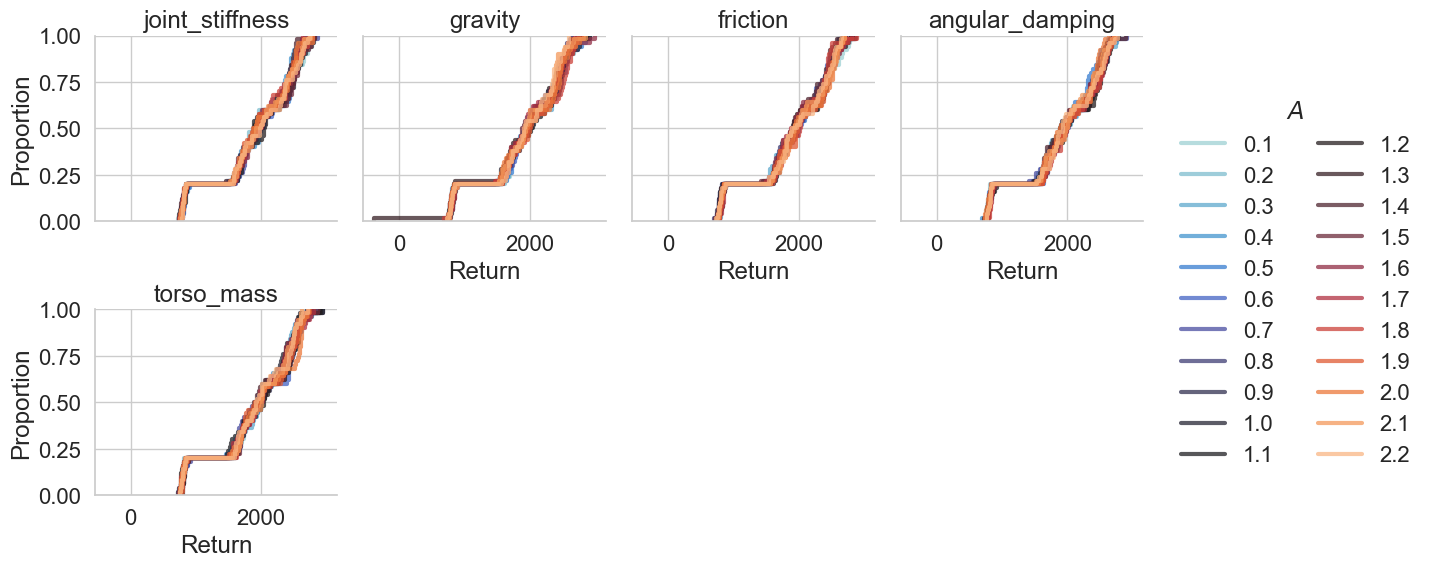

data/hidden_on_variations_new/figures/plot_histogram_CARLHalfcheetah.pdf


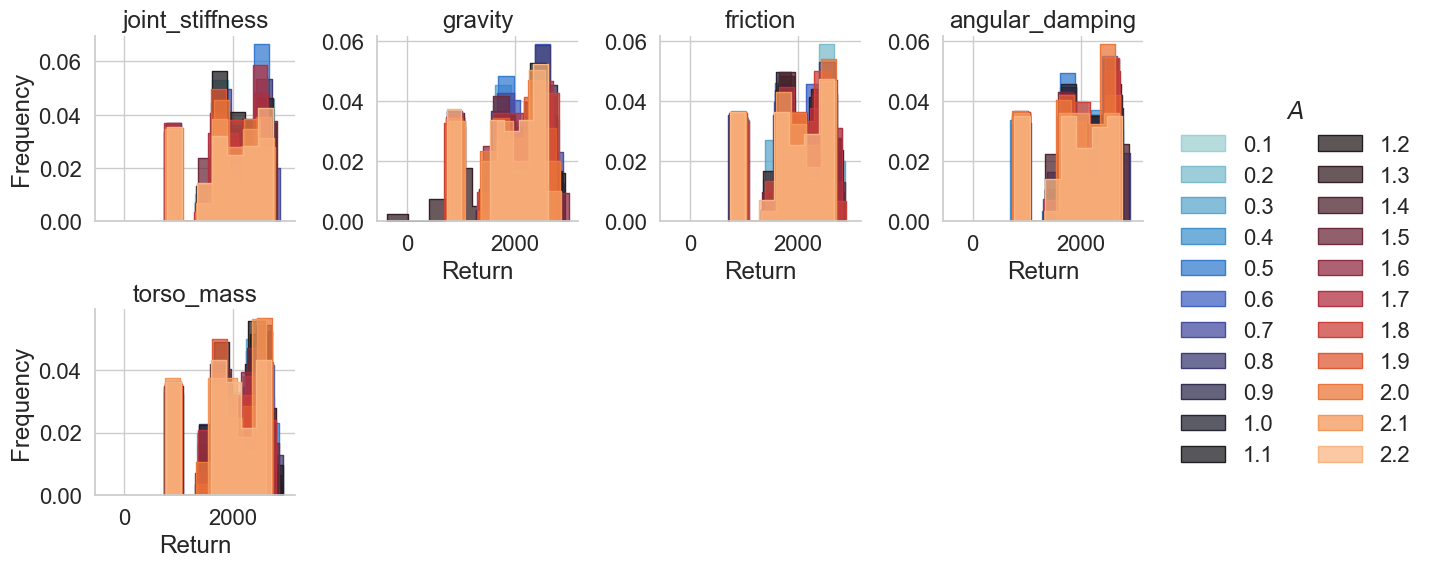

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.45)
sns.set_style("whitegrid")

plot_df = df.copy()
# Only those trained cfs allowed
context_feature_names = ['[]',]  #, "['m', 'l', 'g', 'dt', 'max_speed']"]
plot_df = plot_df[plot_df["context_sampler.context_feature_names"].isin(context_feature_names)]

# Only those visibilities allowed
visibilities = ['hidden']  # , 'cgate_hadamard']
plot_df = plot_df[plot_df["visibility"].isin(visibilities)]

# plot_df = plot_df[plot_df["$A$"] == 1]

# We have hidden [] three times (one for each train magnitude), use only one to be fair
# magnitudes = [0.1]
# plot_df = plot_df[plot_df[key_magnitude_train].isin(magnitudes)]

# Filter by difficulty of test contexts
# magnitudes = [1.1]
# plot_df = plot_df[plot_df[key_magnitude].isin(magnitudes)]

# for c in plot_df.columns:
#     printr(c, plot_df[c].unique())

print(len(plot_df))

legend_ncols = 2

if len(visibilities) > 1:
    col_wrap = None
    col = "visibility"  # "$A$"
    row = "context_feature"  # "context_sampler.context_feature_names"
    hue = key_magnitude  # "visibility"
else:
    col = "context_feature"  # "$A$"
    row = None  # "context_sampler.context_feature_names"
    hue = key_magnitude  # "visibility"
    col_wrap = 4
palette = "icefire"

# ECDF
grid = sns.FacetGrid(data=plot_df, col=col, row=row, hue=hue, legend_out=True, palette=palette, col_wrap=col_wrap)
grid.map_dataframe(sns.ecdfplot, x="return", lw=3, alpha=0.75)
grid.set_titles(row_template="train: {row_name}", col_template="eval: {col_name}")
grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.add_legend(ncols=legend_ncols)
grid.set_xlabels("Return")
# grid.set(xscale="symlog")
# grid.set(xlim=(None,0))
grid.tight_layout()
grid.savefig(outdir / "plot_ecdf.png", dpi=300, bbox_inches="tight")
grid.savefig(outdir.parent / "figures" / f"plot_ecdf_{env_name}.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Histogram
grid = sns.FacetGrid(data=plot_df, col=col, row=row, hue=hue, legend_out=True, sharey=False, palette=palette, col_wrap=col_wrap)
grid.map_dataframe(sns.histplot, x="return", element="step", stat="frequency")
grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.add_legend(ncols=legend_ncols)
grid.set_xlabels("Return")
grid.set_ylabels(label="Frequency", clear_inner=True)
# grid.set(xscale="symlog")
# grid.set(xlim=(None,0))
grid.tight_layout()
grid.savefig(outdir / "plot_histogram.png", dpi=300, bbox_inches="tight")
fn2 = outdir.parent / "figures" / f"plot_histogram_{env_name}.pdf"
print(fn2)
grid.savefig(fn2, dpi=300, bbox_inches="tight")
plt.show()

## Create Latex Figure Code

In [7]:
from __future__ import annotations
from pathlib import Path

content = r"""
\begin{figure}[h]
    \centering
    \includegraphics[width=\linewidth]{filename}
    \caption{captionstr}
    \label{labelstr}
\end{figure}
"""

paths = list((outdir.parent / "figures").glob("*ecdf*.png"))
paths.sort()

C = []
for p in paths:
    env_name = str(p.stem).split('_')[-1]
    caption = f"\\textbf{{{env_name}}}: ECDF Plot. A is the magnitude multiplied with the default value of each context feature."
    replacements = {
        "labelstr": f"fig:{p}",
        "filename": str(Path("figures/hidden_on_variations") / p.name),
        "captionstr": caption,
    }
    new_content = content
    for k, v in replacements.items():
        new_content = new_content.replace(k, v)
        
    C.append(new_content)
    
C = "\n".join(C)

print(C)


\begin{figure}[h]
    \centering
    \includegraphics[width=\linewidth]{figures/hidden_on_variations/plot_ecdf_CARLAcrobotEnv.png}
    \caption{\textbf{CARLAcrobotEnv}: ECDF Plot. A is the magnitude multiplied with the default value of each context feature.}
    \label{fig:data/hidden_on_variations_new/figures/plot_ecdf_CARLAcrobotEnv.png}
\end{figure}


\begin{figure}[h]
    \centering
    \includegraphics[width=\linewidth]{figures/hidden_on_variations/plot_ecdf_CARLCartPoleEnv.png}
    \caption{\textbf{CARLCartPoleEnv}: ECDF Plot. A is the magnitude multiplied with the default value of each context feature.}
    \label{fig:data/hidden_on_variations_new/figures/plot_ecdf_CARLCartPoleEnv.png}
\end{figure}


\begin{figure}[h]
    \centering
    \includegraphics[width=\linewidth]{figures/hidden_on_variations/plot_ecdf_CARLDmcQuadrupedEnv.png}
    \caption{\textbf{CARLDmcQuadrupedEnv}: ECDF Plot. A is the magnitude multiplied with the default value of each context feature.}
    \label{fi

In [8]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ax = sns.boxplot(data=df[df[key] == "['l']"], x=r"$\Delta_{rel}$", y="return", hue="visibility")
# # ax.set_title("l")
# # plt.show()

# print(len(df[df["visibility"] == "cgate_hadamard"]))

# # df = df[df["visibility"] == "hidden"]

# grid = sns.FacetGrid(data=df, col=r"$\Delta_{rel}$", row="visibility", hue="context_sampler.context_feature_names", legend_out=True)
# grid.map_dataframe(sns.kdeplot, x="return")
# grid.set_titles(row_template="{row_name}", col_template="{col_name}")
# grid.add_legend()
# plt.show()


# # grid = sns.FacetGrid(data=df, hue=r"$\Delta_{rel}$", row="context_sampler.context_feature_names", legend_out=True)
# # grid.map_dataframe(sns.kdeplot, x="return")
# # grid.add_legend()
# # grid.set_titles(row_template="{row_name}")
# # plt.show()

# key = "context_sampler.context_feature_names"
# grid = sns.FacetGrid(data=df[(df[key] == "[]") | (df[key] == "['l']")], col=r"$\Delta_{rel}$", row="visibility", hue="context_sampler.context_feature_names", legend_out=True)
# grid.map_dataframe(sns.kdeplot, x="return")
# grid.set_titles(row_template="{row_name}", col_template="{col_name}")
# grid.add_legend()
# plt.show()

# sns.boxplot(data=df[(df[key] == "[]") | (df[key] == "['l']")], x=r"$\Delta_{rel}$", y="return", hue=key)
# plt.show()

